<a href="https://colab.research.google.com/github/kyalan/CUHK-STAT5106-2020/blob/main/Week_12_tf_hub_getting_start.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple Object Detection from tf hub model

In [1]:
try:
    %tensorflow_version 2.x 
except: 
    pass

import tensorflow as tf
import tensorflow_hub as hub

print('Tensorflow\'s version: {}'.format(tf.__version__))

Tensorflow's version: 2.4.1


In [2]:
from google.colab import files

from matplotlib import pyplot as plt
from matplotlib import image as mpimg

import pandas as pd
import numpy as np
from datetime import datetime as datetime
import os, re, sys

### 1. Import picture into colab

In [5]:
uploaded = files.upload()
for k, v in uploaded.items():
    open(k, 'wb').write(v)

Saving test.jpg to test.jpg


In [6]:
image_path = 'test.jpg'
img = mpimg.imread(image_path)
# np.array
print(f'Image imported with shape {img.shape}') 

Image imported with shape (720, 960, 3)


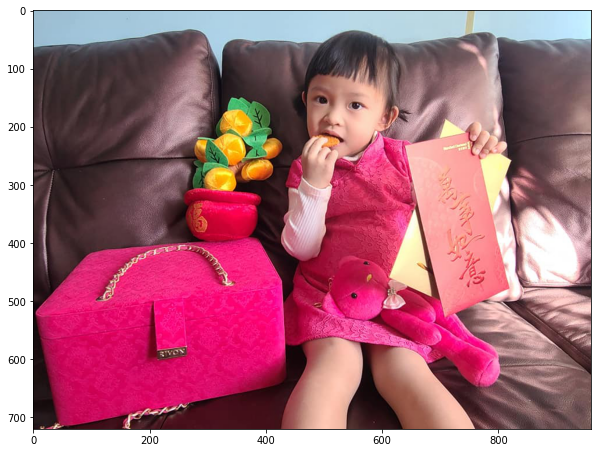

In [7]:
fig = plt.figure(figsize=(10,8))
plt.imshow(img)

### 2. Import Model from tf hub

[Tensorflow Hub Website](https://tfhub.dev/)

In [8]:
# We are going to load the model - Inception Resnet v2
# with Model site: https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1 
model = hub.load('https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1').signatures['default']
print('Model Loaded.')

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model Loaded.


### 3. Influence

According to the spec of inputs: <br>
* The input tensor is a tf.float32 tensor with shape [1, height, width, 3] 
* with values in [0.0, 1.0].
<br> We need to pre-process the input images.

In [43]:
img_np = img.copy()
print(f'Before pre-processing, the image shape = {img_np.shape}')

Before pre-processing, the image shape = (720, 960, 3)


In [44]:
img_np = np.expand_dims(img_np, axis=0) 
img_tf = tf.convert_to_tensor(img_np) 
img_tf = tf.cast(img_tf, tf.float32) / 255.0

Pre-process done.

In [35]:
results = model(img_tf)

result = {key:value.numpy() for key,value in results.items()}
for key, value in result.items():
    print(key, ':', value.shape, value.dtype)

detection_class_names : (100,) object
detection_boxes : (100, 4) float32
detection_scores : (100,) float32
detection_class_labels : (100,) int64
detection_class_entities : (100,) object


### 4. Visualizing

In [12]:
# Clone the tensorflow models repository
!git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 2578, done.
remote: Counting objects: 100% (2578/2578), done.
remote: Compressing objects: 100% (2144/2144), done.
remote: Total 2578 (delta 644), reused 1257 (delta 402), pack-reused 0
Receiving objects: 100% (2578/2578), 32.50 MiB | 28.69 MiB/s, done.
Resolving deltas: 100% (644/644), done.


In [ ]:
# Installing Object Detection API
%%bash
sudo apt install -y protobuf-compiler
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .


In [14]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops

%matplotlib inline

In [39]:
# Loading label map data
category_index = {result['detection_class_labels'][i]: {'id': result['detection_class_labels'][i]
                      , 'name': result['detection_class_entities'][i]} 
                  for i in range(100)}

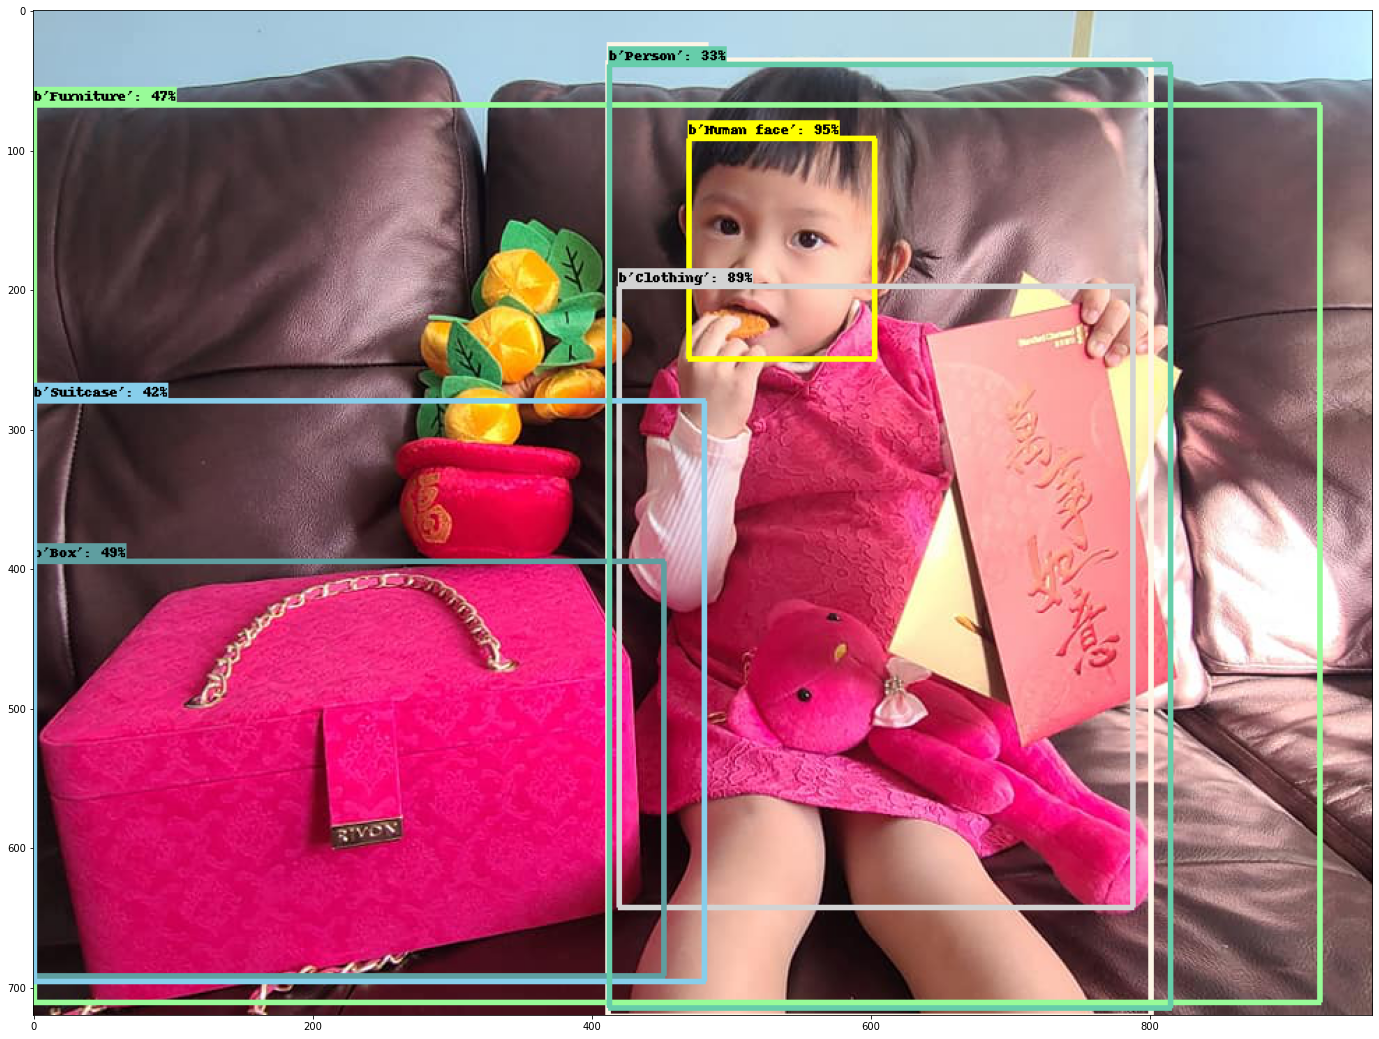

In [45]:
label_id_offset = 0
image_np_with_detections = img_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections[0],
      result['detection_boxes'],
      (result['detection_class_labels'] + label_id_offset).astype(int),
      result['detection_scores'],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.30,
      agnostic_mode=False)

plt.figure(figsize=(24,32))
plt.imshow(image_np_with_detections[0])
plt.show()